# Tested for MobileNetV3

## Dependencies

In [1]:
import os
import pandas as pd
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import numpy as np
from torch.utils.data import DataLoader, Dataset
from src.model3 import MobileNetV3UNet
import torch
import torchvision.transforms.functional as TF
from src.utils import test_performance
from sklearn.metrics import average_precision_score

## Global parameters
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(42)
batch_size = 16
lr = 1e-3
num_epochs = 500


# -- Change this as per your data directory --#
data_path = Path('C:\Projects\python\echoframe\data\EchoNet-Dynamic\EchoNet-Dynamic\\')


file_list_path = os.path.join(data_path,'FileList.csv')
model_path_3 = Path('./models/model3/best_model1.pt')
log_path_3 = Path('./logs/train_log_mobilenet_1.csv')
volume_tracings_path = os.path.join(data_path,'VolumeTracings.csv')
videos_path = os.path.join(data_path,'Videos')

<>:24: SyntaxWarning: invalid escape sequence '\P'
<>:24: SyntaxWarning: invalid escape sequence '\P'
C:\Users\harsh\AppData\Local\Temp\ipykernel_21060\2672989091.py:24: SyntaxWarning: invalid escape sequence '\P'
  data_path = Path('C:\Projects\python\echoframe\data\EchoNet-Dynamic\EchoNet-Dynamic\\')
c:\Projects\python\echoframe_capstone\mainenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Utils

In [2]:
def build_polygons_dict(volume_csv_path):
    """
    Gathers partial tracing rows from VolumeTracings.csv into a dict:
      (base_name, frame_number) -> [ [(x1,y1), (x2,y2), ... ] ]
    """
    tracings_df = pd.read_csv(volume_csv_path)
    
    grouped = tracings_df.groupby(["FileName", "Frame"])
    polygons_dict = {}
    for (filename, frame), group_rows in grouped:
        coords = []
        for _, row in group_rows.iterrows():
            x1, y1 = float(row["X1"]), float(row["Y1"])
            x2, y2 = float(row["X2"]), float(row["Y2"])
            coords.append((x1, y1))
            coords.append((x2, y2))

        base_name = os.path.splitext(filename)[0]
        key = (base_name, int(frame))
        polygons_dict[key] = [coords]
    return polygons_dict

def sort_polygon_coords(coords):
    """
    Sort (x,y) points by angle around the centroid, forming a continuous path.
    """
    centroid = np.mean(coords, axis=0)
    angles = [np.arctan2(y - centroid[1], x - centroid[0]) for (x, y) in coords]
    sorted_idx = np.argsort(angles)
    return [coords[i] for i in sorted_idx]

def create_mask(polygons_dict, video_name, frame_idx, hw_shape):
    """
    Builds a binary 2D mask of shape hw_shape for (video_name, frame_idx).
    Applies a morphological 'close' to fill small holes/gaps.
    Returns a mask in range {0,1}.
    """
    base_name = os.path.splitext(video_name)[0]
    key = (base_name, frame_idx)

    mask = np.zeros(hw_shape, dtype=np.uint8)
    if key not in polygons_dict:
        return mask  # No polygons => empty mask

    for polygon_coords in polygons_dict[key]:
        coords_sorted = sort_polygon_coords(polygon_coords)
        pts = np.array(coords_sorted, dtype=np.int32).reshape((-1, 1, 2))
        cv2.fillPoly(mask, [pts], 255)

    # Morphological closing to fill holes
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    mask = (mask > 127).astype(np.uint8)
    return mask

def read_frame_resized(video_path, frame_idx, resize=(112, 112)):
    """
    Reads the 0-based frame_idx from the video, converts BGR->RGB,
    and resizes to (width,height) if desired. Returns (H,W,3) in RGB.
    If the read fails, returns None.
    """
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        return None
    
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
    ret, frame = cap.read()
    cap.release()

    if not ret or frame is None:
        return None

    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    if resize is not None:
        w, h = resize  # (width, height)
        frame = cv2.resize(frame, (w, h), interpolation=cv2.INTER_AREA)
    return frame

class EchoMaskDataset(Dataset):
    def __init__(self, 
                 df,                
                 polygons_dict,     
                 videos_path,       
                 transform=None,    
                 resize=(112, 112),
                 all_traced_frames=True,
                 offset_frames_by_one=False):

        self.df = df.reset_index(drop=True)
        self.polygons_dict = polygons_dict
        self.videos_path = videos_path
        self.transform = transform
        self.resize = resize
        self.all_traced_frames = all_traced_frames
        self.offset_frames_by_one = offset_frames_by_one

        # 1) Build list of (FileName, frame_idx) samples
        self.samples = []
        
        # Convert polygons_dict keys to a list of (BaseName, Frame)
        all_keys = list(polygons_dict.keys())
        base_frames_map = {}
        for (bn, fr) in all_keys:
            if bn not in base_frames_map:
                base_frames_map[bn] = []
            base_frames_map[bn].append(fr)

        # 2) For each file in df, gather frames from base_frames_map
        for _, row in self.df.iterrows():
            file_name = row["FileName"]  # e.g. 0X100009310A3BD7FC.avi
            base_name = os.path.splitext(file_name)[0]

            if base_name not in base_frames_map:
                continue  # no annotated frames for this file

            frames_this_file = base_frames_map[base_name]

            if len(frames_this_file) == 0:
                continue

            if self.all_traced_frames:
                for fr in frames_this_file:
                    self.samples.append((file_name, fr))
            else:
                es_frame = min(frames_this_file)
                ed_frame = max(frames_this_file)
                self.samples.append((file_name, es_frame))
                if ed_frame != es_frame:
                    self.samples.append((file_name, ed_frame))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        file_name, frame_idx = self.samples[idx]
        video_path = os.path.join(self.videos_path, file_name)

        # If your VolumeTracings.csv is 1-based and OpenCV expects 0-based,
        # offset frames by 1
        if self.offset_frames_by_one:
            frame_idx -= 1
            if frame_idx < 0:
                frame_idx = 0

        # 1) Load the image => shape (H,W,3)
        image_np = read_frame_resized(video_path, frame_idx, resize=self.resize)
        if image_np is None:
            # If something fails, fallback to black image
            w, h = self.resize
            image_np = np.zeros((h, w, 3), dtype=np.uint8)

        # 2) Create the mask => shape (H,W)
        mask_np = create_mask(
            polygons_dict=self.polygons_dict,
            video_name=file_name,
            frame_idx=frame_idx,
            hw_shape=image_np.shape[:2]  # (H,W)
        )

        # mask_np is 0 or 1 => shape (H,W)
        # Expand to (H,W,1)
        mask_np = np.expand_dims(mask_np, axis=-1)

        # 3) Convert to PyTorch Tensors, reorder to CHW
        # image: (3,H,W), mask: (1,H,W)
        image_tensor = torch.from_numpy(image_np).permute(2,0,1).float() / 255.0
        mask_tensor  = torch.from_numpy(mask_np).permute(2,0,1).float()

        # 4) Optional transforms
        if self.transform is not None:
            image_tensor, mask_tensor = self.transform(image_tensor, mask_tensor)

        return image_tensor, mask_tensor,file_name

## Load Data

In [3]:
file_list = pd.read_csv(filepath_or_buffer=file_list_path)
volume_tracings = pd.read_csv(filepath_or_buffer=volume_tracings_path)


file_list['FileName'] = file_list['FileName'].apply(
    lambda x: x if x.endswith('.avi') else x + '.avi'
)
vt_filenames = set(volume_tracings['FileName'])
fl_filenames = set(file_list['FileName'])

missing_files = list(fl_filenames - vt_filenames)
extra_files = list(vt_filenames - fl_filenames)

print(f'Missing files: \n{missing_files}\n\nExtra files: \n{extra_files}')
redacted_files = missing_files+extra_files

file_list = file_list[~file_list['FileName'].isin(redacted_files)]
volume_tracings = volume_tracings[~volume_tracings['FileName'].isin(redacted_files)]

test_df  = file_list[file_list['Split'] == 'TEST']

Missing files: 
['0X2DC68261CBCC04AE.avi', '0X5DD5283AC43CCDD1.avi', '0X5515B0BD077BE68A.avi', '0X234005774F4CB5CD.avi', '0X6C435C1B417FDE8A.avi', '0X35291BE9AB90FB89.avi']

Extra files: 
['0X4F8859C8AB4DA9CB.avi']


In [4]:
polygons_dict = build_polygons_dict(volume_tracings_path)
test_dataset = EchoMaskDataset(
    df=test_df,
    polygons_dict=polygons_dict,
    videos_path=videos_path,
    transform=None,         # or pass a custom transform
    resize=(112, 112),
    all_traced_frames=True, # if you want *all* traced frames
    offset_frames_by_one=False
)

test_loader = DataLoader(test_dataset,batch_size=2)


## Predict

### Helper code

In [5]:
# PX_TO_CM = 0.14

# def closest_point(point, array):
#     diff = array - point
#     dist_sq = np.einsum('ij,ij->i', diff, diff)
#     return np.argmin(dist_sq), dist_sq

# def farthest_point(point, array):
#     diff = array - point
#     dist_sq = np.einsum('ij,ij->i', diff, diff)
#     return np.argmax(dist_sq), dist_sq

# def label_points(p1, p2, p3):
#     """
#     Among the three corners (p1, p2, p3), the apex is the corner
#     that is farthest from the other two corners.
#     """
#     d12 = np.linalg.norm(p1 - p2)
#     d23 = np.linalg.norm(p2 - p3)
#     d13 = np.linalg.norm(p1 - p3)

#     # The corner forming the smallest side is the "mitral valve side."
#     # The remaining corner is apex.
#     if d12 < d23 and d12 < d13:
#         apex = p3
#         mv_1 = p1
#         mv_2 = p2
#     elif d23 < d12 and d23 < d13:
#         apex = p1
#         mv_1 = p3
#         mv_2 = p2
#     else:
#         apex = p2
#         mv_1 = p1
#         mv_2 = p3
#     return apex, mv_1, mv_2

# def simpsons_biplane(cnt, frame):
#     """
#     Returns volume in mL using Simpson’s single-plane formula:
#        V (cm^3) = 8 * (Area_cm^2)^2 / (3 * pi * Length_cm)
#     where:
#       - Area_cm^2 is area in cm^2
#       - Length_cm is the apex-to-base length in cm
#     """
#     # Minimal enclosing triangle
#     area_dummy, tri = cv2.minEnclosingTriangle(cnt)
#     tri = tri.reshape(-1,2)  # shape (3,2)

#     # For each triangle corner, get the closest contour point
#     idx, _ = closest_point(tri[0], cnt[:, 0, :])
#     bp1 = cnt[idx, 0, :]
#     idx, _ = closest_point(tri[1], cnt[:, 0, :])
#     bp2 = cnt[idx, 0, :]
#     idx, _ = closest_point(tri[2], cnt[:, 0, :])
#     bp3 = cnt[idx, 0, :]

#     # Identify apex and MV corners
#     apex, mv1, mv2 = label_points(bp1, bp2, bp3)
#     mid_mv = (mv1 + mv2) / 2.0

#     # Build a line from apex -> mid_mv
#     apex_slope = apex - mid_mv
#     length_slope = np.linalg.norm(apex_slope)
#     if length_slope < 1e-6:
#         return 0.0
#     apex_slope /= length_slope

#     # draw a line that exceeds the image diagonal
#     h, w = frame.shape[:2]
#     diag = int(np.sqrt(h**2 + w**2))
#     line_len = diag * 2

#     start_pt = (apex - line_len * apex_slope).astype(int)
#     end_pt   = (mid_mv + line_len * apex_slope).astype(int)

#     blank = np.zeros_like(frame, dtype=np.uint8)
#     contour_mask = cv2.drawContours(blank.copy(), [cnt], 0, 1, 1)

#     # keep thickening the line until we find at least two intersections
#     # far enough apart (>= ~0.9 * MV diameter).
#     annulus_diam = np.linalg.norm(mv1 - mv2)
#     width = 2
#     dist = 0

#     while True:
#         test_line = cv2.line(blank.copy(),
#                              tuple(start_pt),
#                              tuple(end_pt),
#                              1, width)
#         intersects = np.logical_and(contour_mask, test_line)
#         pts = np.column_stack(np.where(intersects == 1))  # shape (N,2)

#         if pts.size == 0:
#             # No intersections
#             width += 1
#             if width > diag * 2:
#                 return 0.0
#             continue

#         # Find the one furthest from apex
#         # pts is in (row, col) => flip for (x,y)
#         idx_far, arr_far = farthest_point(np.flip(apex), pts)
#         dist = arr_far[idx_far]
#         if (len(pts) >= 2) and (dist >= 0.9 * annulus_diam):
#             # Good enough
#             break
#         width += 1
#         if width > diag * 2:
#             return 0.0

#     # The farthest intersection from apex is the "base intercept"
#     intercept = pts[idx_far]  # (row,col)
#     intercept = np.flip(intercept)  # => (x,y)

#     # measure apex->intercept in px, convert to cm
#     lv_length_px = np.linalg.norm(apex - intercept)
#     lv_length_cm = lv_length_px * PX_TO_CM

#     # contour area in px^2 => cm^2
#     mask_area_px = cv2.contourArea(cnt)
#     mask_area_cm2 = mask_area_px * (PX_TO_CM**2)

#     # Simpson’s single-plane formula => volume in cm^3
#     # which is equal to mL
#     if lv_length_cm < 1e-6:
#         return 0.0
#     volume_mL = (8.0 * mask_area_cm2**2) / (3.0 * np.pi * lv_length_cm)
#     return volume_mL

# def compute_volume_from_mask(mask_np):
#     """
#     mask_np: shape (H,W) in {0,1}.
#     Returns volume in mL via single-plane Simpson’s method.
#     """
#     mask_255 = (mask_np * 255).astype(np.uint8)
#     # Find largest external contour
#     cnts, _ = cv2.findContours(mask_255, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
#     if not cnts:
#         return 0.0
#     max_cnt = max(cnts, key=cv2.contourArea)

#     dummy = np.zeros_like(mask_255)
#     vol_ml = simpsons_biplane(max_cnt, dummy)
#     return vol_ml


### Test

In [6]:
model=MobileNetV3UNet()
test_performance(model=model,
                 test_loader=test_loader,
                 test_df=test_df,
                 device=device,
                 model_path=model_path_3)


c:\Projects\python\echoframe_capstone\mainenv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Projects\python\echoframe_capstone\mainenv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Test Loss (segmentation): 0.12197059575690185
Test Dice (segmentation): 0.9269558649078058
EF Mean Absolute Error (MAE): 6.74988862830732
EF Mean Absolute Percentage Error (MAPE): 13.377623804173286%


## Test Visualizations

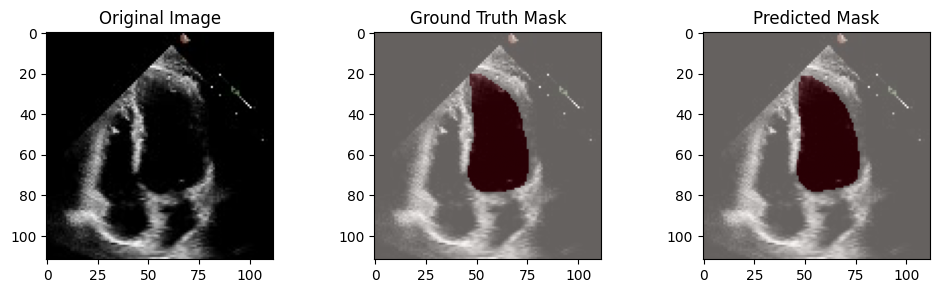

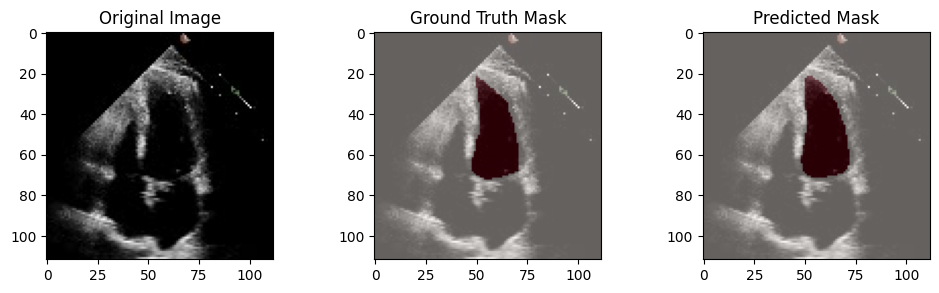

In [7]:
model.eval()
with torch.no_grad():
    for images, masks, file_names in test_loader:
        images = images.to(device)
        masks = masks.to(device)

        # Get raw model outputs
        outputs = model(images)

        # If your model output is a single-channel probability map in [0..1],
        # you might want to threshold it at 0.5 to get a binary mask:
        preds = (outputs > 0.5).float()

        # Plot first 4 samples of this batch (or fewer if batch size < 4)
        num_to_show = min(4, images.size(0))
        for i in range(num_to_show):
            # Convert to CPU and PIL so we can plot easily
            img_np = TF.to_pil_image(images[i].cpu())
            mask_np = TF.to_pil_image(masks[i].cpu().squeeze(0))   # shape: (H,W)
            pred_np = TF.to_pil_image(preds[i].cpu().squeeze(0))   # shape: (H,W)

            # Show Image / Ground Truth / Predicted
            plt.figure(figsize=(10,3))
            
            # Original image
            plt.subplot(1,3,1)
            plt.title("Original Image")
            plt.imshow(img_np)
            
            # Ground-truth
            plt.subplot(1,3,2)
            plt.title("Ground Truth Mask")
            plt.imshow(img_np)
            plt.imshow(mask_np, alpha=0.4, cmap='Reds')
            
            # Prediction
            plt.subplot(1,3,3)
            plt.title("Predicted Mask")
            plt.imshow(img_np)
            plt.imshow(pred_np, alpha=0.4, cmap='Reds')
            
            plt.tight_layout()
            plt.show()

        # Break after one batch if you only want to see a few images
        break


## Get Model Complexity

In [8]:
import torch
from ptflops import get_model_complexity_info
model = MobileNetV3UNet()
model.load_state_dict(torch.load(model_path_3))
model = model.to(device)

# 1) Count trainable parameters
param_count = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {param_count:,}")

# 2) Compute MACs and convert to GFLOPs
input_size = (3, 112, 112)  # (C, H, W)
macs_str, params_str = get_model_complexity_info(
    model, input_size, as_strings=False, print_per_layer_stat=False
)

# Convert MACs to FLOPs and then to GFLOPs
flops = 2 * macs_str  # 1 MAC = 2 FLOPs
gflops = flops / 1e9

print(f"GFLOPs: {gflops:.2f}")
print(f"Params (ptflops): {int(params_str):,}")
  # should match param_count in a formatted string


Total trainable parameters: 3,179,593
GFLOPs: 0.39
Params (ptflops): 3,179,593


In [9]:
from torchsummary import summary
summary(model, input_size=(3, 256, 256), device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]             432
            Conv2d-2         [-1, 16, 128, 128]             432
       BatchNorm2d-3         [-1, 16, 128, 128]              32
       BatchNorm2d-4         [-1, 16, 128, 128]              32
         Hardswish-5         [-1, 16, 128, 128]               0
         Hardswish-6         [-1, 16, 128, 128]               0
            Conv2d-7         [-1, 16, 128, 128]             144
            Conv2d-8         [-1, 16, 128, 128]             144
       BatchNorm2d-9         [-1, 16, 128, 128]              32
      BatchNorm2d-10         [-1, 16, 128, 128]              32
             ReLU-11         [-1, 16, 128, 128]               0
             ReLU-12         [-1, 16, 128, 128]               0
           Conv2d-13         [-1, 16, 128, 128]             256
           Conv2d-14         [-1, 16, 1